In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.usetex = True
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

## Data

In [2]:
n_samples = 10000
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True,
                            )
data_samples = data[:n_samples]

## Prep data

In [3]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=10000,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

In [4]:
vocabulary = tf_vectorizer.vocabulary_

In [5]:
docs = []
for row in tf.toarray():
    present_words = np.where(row != 0)[0].tolist()
    present_words_with_count = []
    for word_idx in present_words:
        for count in range(row[word_idx]):
            present_words_with_count.append(word_idx)
    docs.append(present_words_with_count)

In [8]:
# docs[1]

In [9]:
present_words_with_count

[1909, 2051, 3205, 5441, 8247]

## LDA with Gibbs sampling

In [10]:
D = len(docs)        # number of documents
V = len(vocabulary)  # size of the vocabulary 
T = 10               # number of topics

alpha = 1 / T         # the parameter of the Dirichlet prior on the per-document topic distributions
beta = 1 / T        # the parameter of the Dirichlet prior on the per-topic word distribution

In [11]:
z_d_n = [[0 for _ in range(len(d))] for d in docs]  # z_i_j
theta_d_z = np.zeros((D, T))
phi_z_w = np.zeros((T, V))
n_d = np.zeros((D))
n_z = np.zeros((T))

## Initialize the parameters
# m: doc id
for d, doc in enumerate(docs):  
    # n: id of word inside document, w: id of the word globally
    for n, w in enumerate(doc):
        # assign a topic randomly to words
        z_d_n[d][n] = n % T
        # get the topic for word n in document m
        z = z_d_n[d][n]
        # keep track of our counts
        theta_d_z[d][z] += 1
        phi_z_w[z, w] += 1
        n_z[z] += 1
        n_d[d] += 1

In [12]:
for iteration in tqdm(range(10)):
    for d, doc in enumerate(docs):
        for n, w in enumerate(doc):
            # get the topic for word n in document m
            z = z_d_n[d][n]

            # decrement counts for word w with associated topic z
            theta_d_z[d][z] -= 1
            phi_z_w[z, w] -= 1
            n_z[z] -= 1

            # sample new topic from a multinomial according to our formular
            p_d_t = (theta_d_z[d] + alpha) / (n_d[d] - 1 + T * alpha)
            p_t_w = (phi_z_w[:, w] + beta) / (n_z + V * beta)
            p_z = p_d_t * p_t_w
            p_z /= np.sum(p_z)
            new_z = np.random.multinomial(1, p_z).argmax()

            # set z as the new topic and increment counts
            z_d_n[d][n] = new_z
            theta_d_z[d][new_z] += 1
            phi_z_w[new_z, w] += 1
            n_z[new_z] += 1

  0%|          | 0/10 [00:00<?, ?it/s]

## Results

Text(0.5, 1.0, 'Topic distribution $theta_i$ for document 1')

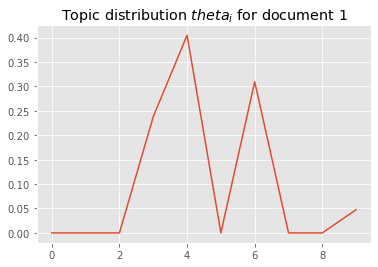

In [13]:
i = 1
plt.plot(theta_d_z[i]/ sum(theta_d_z[i]));
plt.title("Topic distribution $theta_i$ for document {}".format(i))

In [14]:
inv_vocabulary = {v: k for k, v in vocabulary.items()}
n_top_words = 10
for topic_idx, topic in enumerate(phi_z_w):
    message = "Topic #%d: " % topic_idx
    message += " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic #0: 00 10 25 15 20 16 team 12 11 14
Topic #1: edu file com space use mail information available ftp program
Topic #2: like just don use used know new problem time good
Topic #3: use windows does drive window scsi know problem like using
Topic #4: people just said god don know say right think like
Topic #5: think don like just know good people time year mr
Topic #6: god think don people jesus just does gun life believe
Topic #7: key government people armenian encryption law public chip armenians use
Topic #8: ax max g9v db b8f pl a86 75u bhj 1t
Topic #9: cx w7 c_ mv ah 17 hz t7 uw chz
